# Práctico 5: Introducción a las redes neuronales para grafos

# Introduction

En este práctico vamos a introducirnos en redes neuronales con datos en grafos y sus distintas aplicaciones.

In [ ]:
!pip install python-igraph > /dev/null
!pip install cairocffi > /dev/null

!pip freeze | grep torch #ver compatibilidad entre librerías
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu112.html > /dev/null
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu112.html > /dev/null
!pip install -q torch-geometric > /dev/null
!pip install stellargraph > /dev/null

!nvidia-smi #ver datos de la GPU

In [ ]:
import igraph as ig
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import time
from pathlib import Path
import os

from sklearn import model_selection
from sklearn import preprocessing, model_selection

from IPython.display import display, HTML, Javascript

from collections import defaultdict

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

In [ ]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph import datasets

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

#1) Clasificación de Vértices

## 1.1) Comunidades en el Club de karate

Vamos a trabajar con el grafo del club de karate. 

Nuestro objectivo será encontrar la comunidad a la que pertenece cada nodo, sabiendo la comunidad a la que pertenecen solo algunos de ellos.

In [ ]:
!wget -q "https://raw.githubusercontent.com/prbocca/na101_master/master/homework_05_gnn/karate.graphml" -O "karate.graphml"

In [ ]:
g_karate = ig.load("karate.graphml")
g_karate.summary()

Para calcular la communidad de cada nodo, vamos a utilizar la noción de modularidad, con la que trabajaremos más a fondo en el práctico siguiente.

In [ ]:
N = g_karate.vcount()

In [ ]:
cl = g_karate.community_optimal_modularity()
cl.modularity

Podemos observar que se encuentran 4 comunidades. Podemos graficarlas asignandoles un color a cada una.

In [ ]:
set(cl.membership)

In [ ]:
pal = ig.drawing.colors.ClusterColoringPalette(4) # Creamos una paleta de colores
g_karate.vs["color"] = pal.get_many(cl.membership) #asignamos un color por comunidad

visual_style = {"bbox": (400, 400)}
ig.plot(g_karate, **visual_style)

Crearemos ahora una **mascara con 2 nodos de cada comunidad que vamos a usar más tarde para entrenar**.

Una mascara es un array de 0s y 1s de largo igual a la cantidad de nodos y vale 1 si el nodo se encuentra seleccinado y 0 sino.

A continuación crea una mascara que seleccione los nodos cuya ETIQUETA sea una de las siguientes: `6, 7, H, 4, 26, 28, 23, 10`. 

In [ ]:
train_mask = np.zeros(N, dtype=np.bool)

### START CODE HERE
### END CODE HERE

print(train_mask.sum())
print(train_mask)

##1.2) Pasaje de mensajes entre nodos (sin entrenamiento)

En esta primera parte del práctico, vamos a trabajar sobre un ejemplo inspirado en el [BLOG de Thomas Kipf](https://tkipf.github.io/graph-convolutional-networks/).

Escribiremos una red neuronal para grafos utilizando librerías básicas, de forma de ilustrar lo que sucede al detalle. La red que construiremos será una GCN (Graph convolutional network) de dos capas.

Una de las formas de entender las redes neuronales para grafos es mediante el **pasaje de mensajes (message-passing)**. 
La idea principal se puede resumir como: en cada etapa, cada nodo envia a sus vecinos su "mensaje" y a su vez, cada nodo recomputa un nuevo mensaje a partir de los mensajes recibidos de sus vecinos.

### 1.2.1) Construir una red GCN con 2 capas

#### Cálculos preliminares: matriz normalizada $\tilde{A}$ .
Comenzemos a construir la red. El primer paso consiste en calcular la matrix normalizada:
  $$\tilde{A} = \hat{D}^{-\frac 1 2}\hat{A}\hat{D}^{-\frac 1 2} $$

donde $\hat{A} = A + I_N$ y $\hat{D}_{ii} = \sum_{j} \hat{A}_{ij}$

In [ ]:
A = np.array(g_karate.get_adjacency().data) #matriz de adyacencia
A

In [ ]:
def is_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print("La matriz es simetrica porque el grafo es no dirigido. Simetrica: " + str(is_symmetric(A)) + ". Dirigido: " + str(g_karate.is_directed()))

In [ ]:
A_hat = A + np.eye(N)
A_hat

In [ ]:
D_hat = np.diag(A_hat.sum(axis=1)) # sum rows
D_hat = np.linalg.inv(np.sqrt(D_hat))
D_hat

In [ ]:
# Complete el siguiente código para calcular A_sim

# Tip: usar definición y matrices A_hat y D_hat
### START CODE HERE
### END CODE HERE
A_sim

#### Estructura de la red.

Construiremos una red de dos capas.

En cada capa, $l$, se construye un espacio embebido de vértices (un vector oculto $H_l$) a partir de los pesos y el espacio embebido de la capa anterior.
En particular, cada capa de la red tiene la siguiente forma:

$$ H_{j+1} = f(\tilde{A} H_j W_j )$$

La red con la que vamos a trabajar tendrá la siguiente estructura

* $W^0 \in \mathbb{R}^{N \times 4}$
* $W^1 \in \mathbb{R}^{4 \times 4}$
* $W^2 \in \mathbb{R}^{4 \times 2}$ (queremos una representación 2D)

* $H_0 = X$, donde $X$ es una matrix de atributos de cada nodo, pero como en este caso no tenemos ninguno, usamos la matrix identidad.

* $f = \tanh()$, función de activación.

Observe que las dimensiones de los pesos $W$ están calculados de tal forma de que las multiplicaciones tengan sentido.




In [ ]:
r = np.random.RandomState(1) # 1 is good. Para reproducir los resultados

# la identidad como matriz de atributos de vértices
X = np.eye(N)
H_0 = X

#inicializamos los pesos de forma aleatoria
cw0 = np.sqrt(6 / (N + 4))
W_0 = r.uniform(-1, 1, size=(N, 4)) * cw0
cw1 = np.sqrt(6 / (4 + 4)) 
W_1 = r.uniform(-1, 1, size=(4, 4)) * cw1
cw2 = np.sqrt(6 / (4 + 2))
W_2 = r.uniform(-1, 1, size=(4, 2)) * cw2

#calculamos los parámetros de cada capa
H_1 = np.tanh(A_sim.dot(H_0).dot(W_0))
H_2 = np.tanh(A_sim.dot(H_1).dot(W_1))
Z = np.tanh(A_sim.dot(H_2).dot(W_2))
Z

Visualizamos el resultado.

No esperamos sea bueno porque aún no entrenamos la red (no aprendimos los pesos).

In [ ]:
visual_style["layout"] = [tuple(x) for x in Z] #posicionamos los vértices según la salida de la red

ig.plot(g_karate, **visual_style)

Hasta ahora implementamos una red neuronal para grafos con dos capas y calculamos el resultado de 1 iteración del algoritmo. 

Para que esta red pueda aprender, necesitamos entrenarla. Eso significa modificar las matrices de pesos $W$ para que el resultado sea el buscado.

La forma de encontrar estos pesos es usando una técnica llamada descenso por gradientes, pero por suerte, no tenemos que implementarla desde cero. Vamos a usar dos bibliotecas que nos van a ayudar con esta tarea.

##1.3) Entrenando la red con `Pytorch Geometric`

Vamos a usar pytorch para implementar la misma red neuronal con la que trabajamos antes. Usar PyTroch nos permite no tener que implementar nosotros mismos un algoritmo de decenso por gradientes.

El modulo `geometric` de la biblioteca `pytorch` permite construir redes neuronales para grafos y ya cuenta con muchas de las capas que necesitamos.


In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

##podría usarse la red de karate ya en el formato CCO, pero optamos por mostrar como crearla
#from torch_geometric.datasets import KarateClub
#dataset = KarateClub() 

Primero que nada necesitamos crear el grafo en un formato que PyTorch entiende. Este se llama COO. La descripción se encuentra [aquí](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html)

In [ ]:
# Las aristas tienen que ser especificadas en ambas direcciones si el grafo es no dirigido
edges = []
for edge in g_karate.es:
  edges.append([edge.source, edge.target])
  edges.append([edge.target, edge.source])

edges = torch.LongTensor(np.array(edges).T) 

features = torch.Tensor(np.eye(N)) # Nuevamente, como no tenenmos features, usamos la matrix identidad.

y = torch.Tensor(cl.membership) 
y = y.type(torch.LongTensor)

data = Data(x=features, edge_index=edges, y=y, train_mask=train_mask)
dataset = DataLoader(data)

In [ ]:
# Podemos imprmir algunos atributos del grafo
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

En el siguiente fragmento de código, `GNConv` implementa la capa que hasta ahora estabamos calculando como $\tilde{A}H_iW_i$.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        # En las 3 lineas siguientes, especificamos las capaz con los tamaños
        # que ya estabamos usando. 
        self.conv1 = GCNConv(N, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)

        # Esta última capa mapea la salida en dos dimensiones a un vector
        # de dimension 4 que se vamos a usar para calcular el "error"
        self.classifier = Linear(2, len(set(cl.membership)))

    def forward(self, x, edge_index):

        # la capa GCN no cuenta con la función de activación
        # por lo que la tenemos que calcular aparte.
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

Igual que la vez anterior, podemos crear la red y evaluar el grafo sin entrenar.

In [ ]:
model = GCN()

out, z = model(data.x, data.edge_index)

In [ ]:
visual_style["layout"] = [tuple(x) for x in z]
ig.plot(g_karate, **visual_style)

Ahora pasemos a entrenar los pesos para que la salida de la red se parezca a las comunidades de los vértices de entrenamiento.

Comencemos por definir algunas funciones auxiliares.

In [ ]:
%matplotlib inline
#import torch
#import networkx as nx
#import matplotlib.pyplot as plt

def visualize(h, color, epoch=None, loss=None):
    """
    Esta es una función auxiliar para visualizar el entrenamiento
    """
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set1")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

Ahora es donde vamos a entrenar la red.

Primero creamos una nueva red. Luego definimos la función objectivo, en este caso [CrossEntropyLoss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy).
Luego definimos el algoritmo que vamos a usar para entrenar la red, en este caso es [Adam](https://youtu.be/JXQT_vxqwIs).

La función `train()` encapsula una iteración de entrenamiento. Luego, esto se repite tantas veces como "epochs" tengamos, en este caso 1000.

In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(1000):
    loss, h = train(data)
    if epoch % 100 == 0:
     visualize(h, color=data.y, epoch=epoch, loss=loss)
     time.sleep(0.3)

Una vez que el modelo termino de entrenar podemos evaluarlo y obtener la clasificación de cada nodo.

In [ ]:
 out, z = model(data.x, data.edge_index) # Evaluar el modelo

 print(out.shape)

In [ ]:
print("Las comunidades reales: \n", y) 

print("Las comunidades predichas: \n", out.detach().numpy().argmax(axis=1)) # Calcular la clasificación de cada nodo

El algoritmo busca separar lo más posible los vértices de cada comunidad, esto no es lo mismo que mostrarlas bien.

In [ ]:
visual_style["layout"] = [tuple(x) for x in z]
ig.plot(g_karate, **visual_style)

##1.4)  Entrenando la red con `StellarGraph`

Podemos repetir el mismo proceso pero usando la librería `StellarGraph`, que ya usamos en prácticos anteriores.

Esta parte del práctico está basada en el siguiente [blog post](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html)

In [ ]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection

Para cargar un grafo a `StellarGraph` tenemos que pasar de `igraph` a `pandas` y luego a `StellarGraph`.

Para esto primero creamos una lista de aristas (no dirigidas y las guardamos en un dataframe)

In [ ]:
edges = pd.DataFrame([[e.source, e.target] for e in g_karate.es],
                     columns = ["source", "target"])
edges

In [ ]:
sg_karate = sg.StellarGraph(edges=edges)

Como vamos a ver, el grafo todavía no tiene los atributos necesarios. Estos los vamos a agregar a continuación.

In [ ]:
print(sg_karate.info())

In [ ]:
node_features = pd.DataFrame({"class": cl.membership})
display(node_features.head())

sg_karate = sg.StellarGraph(node_features, edges) #agrego comunidad

In [ ]:
print(sg_karate.info()) #ahora tiene el atributo 'class'

Ahora tenemos que elegir que nodos vamos a usar para entrenar y cuales para testing. Esto podríamos hacerlo con la máscara definida anteriormente, pero optamos por sortearlos nuevamente con fines ilustrativos. 

Atención: Esto **no significa que vayamos a usar un subgrafo para entrenar**. Simplemente que a la hora de calcular la función objetivo vamos a tener en cuenta solo alguno de los vértices (pero usaremos todo el grafo para construir la red de mensajes).

En particular, vamos a elegir solo 2 vértices de cada clase.

In [ ]:
train = node_features.groupby("class").sample(2, random_state=42).copy()
train

El resto de los vértices serán para testing.

In [ ]:
test = node_features[~node_features.index.isin(train.index)].copy()
display(test.head())

print(test.shape) # 26 + 8 = 34

Para usar StellarGraph necesitamos transformar la categoría clase en una lista de atributos binarios donde cada columna indica si el nodo es de dicha clase o no. Esto se conoce como `One Hot Encoding`

In [ ]:
train_dummy = pd.get_dummies(train["class"])
display(train_dummy.head())

test_dummy = pd.get_dummies(test["class"])
display(test_dummy.head())

Los próximos pasos son necesarios para que StellarGraph pueda trabajar con los datos que les pasamos.

In [ ]:
generator = FullBatchNodeGenerator(sg_karate, method="gcn") # 

In [ ]:
train_gen = generator.flow(
    train_dummy.index, # Estos son los indices usados para el set de train
    train_dummy.values, # Estos es una matrix de numpy con los valores correspondientes a las clases
    use_ilocs=False # Esto se usa para indicar que los indices son "nombres" y no posisciones
)

In [ ]:
gcn = GCN(layer_sizes=[4, 4, 2], activations=["tanh", "tanh", "tanh"], generator=generator, dropout=0)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
predictions = layers.Dense(units=train_dummy.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
)

In [ ]:
sg.utils.plot_history(history)

Finalmente, podemos revisar el resultado de la clasificación en el set de test.

In [ ]:
test_gen = generator.flow(test_dummy.index, test_dummy.values)

In [ ]:
out = model.predict(test_gen)

print(out.shape)

In [ ]:
print("Las comunidades reales: \n", test['class'].to_numpy()) 

print("Las comunidades predichas: \n", out[0].argmax(axis=1)) # Calcular la clasificación de cada nodo

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

Y en todo el conjunto de datos, para compararnos con las soluciones anteriores.

In [ ]:
all_dummy = pd.get_dummies(node_features["class"])
display(all_dummy.head())

all_gen = generator.flow(all_dummy.index, all_dummy.values)

out = model.predict(all_gen)
print(out.shape)

print("Las comunidades reales: \n", node_features['class'].to_numpy()) 
print("Las comunidades predichas: \n", out[0].argmax(axis=1)) # Calcular la clasificación de cada nodo

#2) Clasificación de Grafos

#2.1) Entrenando con `Pytorch Geometric`

Finalmente, vamos a trabajar sobre un problema de clasificación donde el objetivo va a ser clasificar varios grafos como objetos (y no nodos de forma independiente).

Para esto vamos a usar un dataset que contiene grafos que reperesentan moléculas. Donde cada grafo es clasificado en dos clases posibles.

Esta parte del práctico se encuentra basada en el siguiente [notebook](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=j11WiUr-PRH_)

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
# Pregunta: tienen todos los grafos la misma cantidad de vértices?
# Si la respuestá es sí, tiene todos las misma cantidad de aristas?
# Si la respuesta es no, cual es la cantidad de vértices mínima y máxima de los grafos?

### START CODE HERE
### END CODE HERE


Para este problema vamos a experimentar con algunas herramientas nuevas.

Primero, vamos a separar algunos grafos para nuestro conjunto de entrenamiento y otros para nuestro conjunto de testeo.

A diferencia de los ejemplos anteriores donde pasabamos todo el grafo al mismo tiempo a la red, en este ejemplo vamos a usar lo que se conoce como `batch`. Esto consiste en separar de forma aleatoria el conjunto de datos y pasarle a la red neuronal solo un conjunto de datos a la vez. 
Cuando todos los datos pasaron una vez, repetimos el proceso. 

En resumen, cada `epoch` (como habíamos visto antes) consiste en varias pasadas de distintos `batches`. 

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# Esta arquitectura es casi igual a la del primer ejemplo.
# Cambiamos las tanh() por relu() y el tamaño de los pesos


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train() # Enables dropout

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval() # Disable dropout

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
'''
La cantidad de grafos en cada batch parece ser diferente.

1. Eso significa que la arquitectura cambia para cada batch? Cómo funcionaría eso?
2. Si la arquitectura no cambia, como se justifica que el modelo acepte entradas
de distintos tamaños?
'''
### START CODE HERE
### END CODE HERE


In [ ]:
# Pregunta: ¿qué hace la función `global mean pool`?

### START CODE HERE
### END CODE HERE


## 2.2) Clasificación de grafos enteros con `StellarGraph`

Resolveremos el mismo problema de clasificación para los datos MUTAG, usando la librería `StellarGraph`.


Esta parte del práctico se encuentra basada en el siguiente [ejemplo](https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/gcn-supervised-graph-classification.html)

In [ ]:
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph import datasets

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#%pip install -q stellargraph[demos]==1.2.1
try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

El conjunto de datos se encuetra como ejemplo de la librería. Aprovechamos y lo cargamos de allí.

La variable `graphs` es una lista de grafos en formato `StellarGraph`.

In [ ]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [ ]:
# Pregunta: ¿es el mismo dataset que el usado en la sección anterior?

### START CODE HERE
### END CODE HERE


A continuación unas funciones auxiliares que necesitamos para crear y entrenar el modelo.

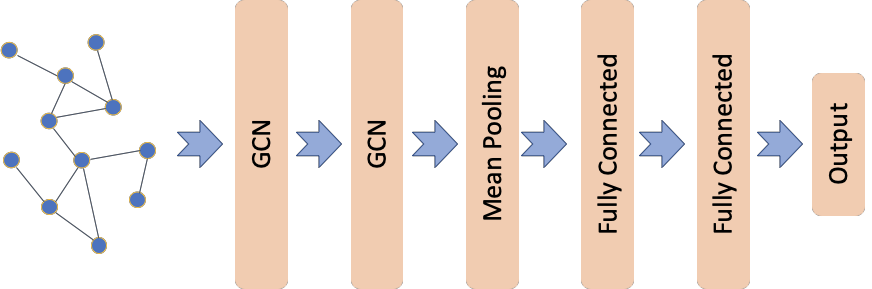

In [ ]:
def create_graph_classification_model(generator):
    """
    Create a tf.Keras graph classification model using StellarGraph’s GraphClassification class together with standard tf.Keras layers, e.g., Dense.

    The input is the graph represented by its adjacency and node features matrices. 
    The first two layers are Graph Convolutional with each layer having 64 units and relu activations. 
    The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. 
    The graph representation is input to two fully connected layers with 32 and 16 units respectively and relu activations. 
    The last layer is the output layer with a single unit and sigmoid activation.
    """
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model


def train_fold(model, train_gen, test_gen, es, epochs):
    """
    The method train_fold is used to train a graph classification model for a single fold of the data.
    """

    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc


def get_generators(train_index, test_index, graph_labels, batch_size):
    """
    Generate datasets for training
    """

    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

Primero debemos crear un generador de datos, para clasificación de grafos usamos `PaddedGraphGenerator()`.

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

A continuación definimos los parámetros de entrenamiento. A destacar, usaremos un mecanimos de finalizar el entrenamiento en forma temprana para evitar sobreajustes.

In [ ]:
epochs = 200  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [ ]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

A continuación, usamos las funciones auxiliares y los parámetros de entrenamiento en un bucle de entrenamiento.

El bucle repite `n_repeats=5` un entrenamiento completo de validación cruzada k-fold (con `folds=10`).



In [ ]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

La calidad del resultado es similar a la obtenida con `Pytorch`.

In [ ]:
print(f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%")